# **Name:** Subhadeep Chaudhuri | **Roll no.** : 19i190010

### **Question 1:** Weighted Majority Algorithm


In [ ]:
###########################################
## Importing the necessary packages
###########################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import scipy.stats as ss
from tqdm import tqdm

In this block, we define the main algorithm implementation. 

- **Inputs to the algorithm:**
> - Horizon $T$, 
> - Number of experts $d$
> - $\Delta$ for specifying the probability distribution governing the losses
> - $c$ which will be used to calculate the learning rate $\eta = c\sqrt{\frac{2log(d)}{T}}$

- We create a loss matrix of shape $T \times d$, where the $i^{th}$ row denotes the losses of the $d$ experts at time round $i$. We create the entire loss matrix at once to reduce time complexity.
- **Output:** Regret of the algorithm, $R(T)$ =  $\sum_{t = 1}^{T} <w_t, V_t> - \min_{i \in [d]}\sum_{t = 1}^{T}V_{ti}$

In [ ]:
################################################
## Implementing the weighted majority algorithm
################################################

def weighted_majority(T, d, delta, c):

    ## Creating a loss matrix of size (T x d)
    ## i-th row denoting loss of all experts in i-th round 
    #######################################################
    loss = np.zeros((T, d))
    for i in range(T):
        loss[i][0:-2] = np.random.binomial(n=1, p = 0.5, size = d-2)              ## For the first 8 arms 
        loss[i][-2] = np.random.binomial(n=1, p = 0.5-delta, size = 1)            ## For the 9-th arm
        if i <= T/2:
            loss[i][-1] = np.random.binomial(n=1, p = 0.5+delta, size = 1)        ## For the 10-th arm when t <= T/2
        else:
            loss[i][-1] = np.random.binomial(n=1, p = 0.5-(2*delta), size = 1)    ## For the 10-th arm when t > T/2
    
    ## Initializing and creating necessary variables
    #######################################################
    w = np.ones(d)                         ## Weight vector initialized. W_1 = (1,1,...,1)
    eta = c*np.sqrt(2*np.log(d)/T)         ## Learning rate eta
    total_cost = 0                         ## Variable to store total cost incurred throughout

    ## Iteration over time. Main loop of the algo
    #######################################################
    for i in range(T):
        w_normalized = np.divide(w, np.sum(w))     ## Normalizing the weights vector
        cost = np.dot(w_normalized, loss[i])       ## Cost incurred: <w_t, V_t>
        total_cost += cost                         ## Adding up the cost to calculate cumulative cost over all rounds
        w = np.multiply(w, np.exp(-eta*loss[i]))   ## Update step w_t+1 = w_t* exp(-eta*V_t)
    
    best_arm_loss = np.min(np.sum(loss, axis = 0)) ## Loss for the arm with minimum loss i.e. best action
    regret = total_cost - best_arm_loss            ## sum(<w_t, V_t>) - min{over all arms i} sum(V_ti)

    return regret


This method implements the Weighted Majority algorithm over different runs. The regret obtained from each run of the algorithm are then stored in an array for further use.

In [ ]:
#####################################################################
## Method to call the weighted majority algorithm over multiple runs
#####################################################################

def WM_over_runs(runs, *args):

    ## Checking the validity of the arguments required in weighted_majority algorithm
    #################################################################################
    if args is None:
        err_msg = 'Arguments T, d, delta, c are missing!'
        raise ValueError(err_msg)
    elif len(args)< 4 :
        err_msg = 'All arguments not given. Check again!'
        raise ValueError(err_msg)
    else:
        T = args[0]
        d = args[1]
        delta = args[2]
        c = args[3]
    
    ## Storing the regret obtained for each run in an array
    #######################################################
    regret_array = np.zeros(runs)
    for i in range(runs):
        regret_array[i] = weighted_majority(T, d, delta, c)     ## Looping over runs and storing the regret in each run
    
    return regret_array

This method is used to obtain the required plot showing the average regrets over multiple runs along with 95% confidence intervals for different choices of $c$ i.e. for different learning rates $\eta$.

In [ ]:
###############################################################################
## Method to plot the required results and store the mean regret for each eta
###############################################################################

def plot_function(runs, T, d, delta, c_array):

    ## Calculating the average regret over multiple runs for each eta
    ## 95% CI are to be created. So we store the error terms as well
    ##################################################################
    mean_regret_array = []
    regret_error = []
    for i in range(len(c_array)):
        regret_array_c =  WM_over_runs(runs, T, d, delta, c_array[i])                ## Looping over all the choices of c, i.e. different eta 
        mean_regret_array.append(np.mean(regret_array_c))                            ## Storing the mean regrets over multiple runs
        regret_error.append(ss.t.ppf(0.95, df = runs -1)*ss.sem(regret_array_c))     ## Storing the standard error over multiple runs for the 95% CI
    mean_regret_array = np.array(mean_regret_array)                                  ## Converting to np.array datatype
    regret_error = np.array(regret_error)                                            ## Converting to np.array datatype
    eta_array = c_array*np.sqrt(2*np.log(d)/T)                                       ## Storing the eta values considered for different c

    ## Plotting the regret for each eta along with the 95% CI
    ###############################################################
    plt.errorbar(eta_array, mean_regret_array, regret_error, marker = 'o', color = 'blue', label='Weighted_Majority')
    plt.fill_between(eta_array, mean_regret_array - regret_error, mean_regret_array + regret_error, color='blue', alpha=0.2)
    plt.title(f'Pseudo Regret Plot for Weighted Majority Algorithm\n (T = {T}, runs = {runs})', fontweight = 'bold')
    plt.xlabel('Learning Rate ($\eta$)')
    plt.ylabel('(Pseudo)Regret')
    plt.show()
    return mean_regret_array, regret_error

In [ ]:
###########################################
## Parameters for the problem
###########################################
delta = 0.1           ## Parameter of distribution of loss for environment
T = 100000            ## Horizon
d = 10                ## No. of experts
c_array = np.arange(0.1, 2.11, 0.2).astype(np.double).round(2)        ## Considered choices of c
runs = 100            ## No. of runs

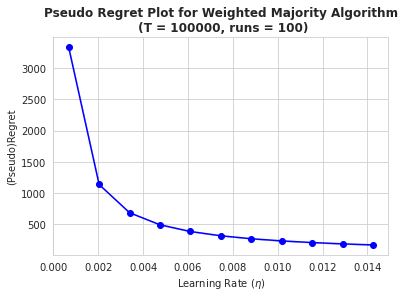

In [ ]:
avg_regrets, bar_widths = plot_function(runs, T, d, delta, c_array)